# Cleanlab 2.0: The Workflows of Data-centric AI

In this tutorial, you will learn how to easily incorporate the new and improved [cleanlab 2.0](https://github.com/cleanlab/cleanlab) into your ML development workflows to:

- Automatically find label issues lurking in your data.
- Score the label quality of every example in your dataset.
- Train robust models in the presence of label issues.
- Identify overlapping classes that you can merge to make the learning task less ambiguous.
- Generate an overall label health score to track improvements in your labels as you clean your datasets over time.

This tutorial provides an in-depth survey of many possible different ways that cleanlab can be utilized for Data-Centric AI. If you have a different use-case in mind that is not supported, please [tell us about it](https://github.com/cleanlab/cleanlab/issues)!

**cleanlab is grounded in theory and science**. Learn more: [Research Publications](https://cleanlab.ai/research)  |  [Label Errors found by cleanlab](https://labelerrors.com/)  |  [Examples using cleanlab](https://github.com/cleanlab/examples)


## Install dependencies and import them

You can use pip to install all packages required for this tutorial as follows:

```
!pip install sklearn matplotlib
!pip install cleanlab
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation.
dependencies = ["cleanlab", "sklearn", "matplotlib"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/cleanlab/cleanlab.git@9dd8420e6771fab213735c98065a2b65dd3a5a4c
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
import numpy as np
import cleanlab
from cleanlab.classification import CleanLearning
from cleanlab.benchmarking import noise_generation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from numpy.random import multivariate_normal
from matplotlib import pyplot as plt

## Create the data used for this tutorial (can skip these details)


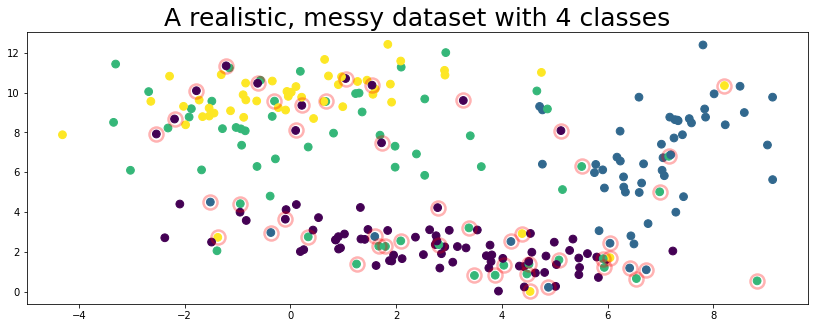

In [3]:
SEED = 0

def make_data(
    means=[[3, 2], [7, 7], [0, 8], [0, 10]],
    covs=[
        [[5, -1.5], [-1.5, 1]],
        [[1, 0.5], [0.5, 4]],
        [[5, 1], [1, 5]],
        [[3, 1], [1, 1]],
    ],
    sizes=[100, 50, 50, 50],
    avg_trace=0.8,
    seed=SEED,  # set to None for non-reproducible randomness
):
    np.random.seed(seed=SEED)

    K = len(means)  # number of classes
    data = []
    labels = []
    test_data = []
    test_labels = []

    for idx in range(K):
        data.append(
            np.random.multivariate_normal(
                mean=means[idx], cov=covs[idx], size=sizes[idx]
            )
        )
        test_data.append(
            np.random.multivariate_normal(
                mean=means[idx], cov=covs[idx], size=sizes[idx]
            )
        )
        labels.append(np.array([idx for i in range(sizes[idx])]))
        test_labels.append(np.array([idx for i in range(sizes[idx])]))
    X_train = np.vstack(data)
    y_train = np.hstack(labels)
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_labels)

    # Compute p(y=k) the prior distribution over true labels.
    py_true = np.bincount(y_train) / float(len(y_train))

    noise_matrix_true = noise_generation.generate_noise_matrix_from_trace(
        K,
        trace=avg_trace * K,
        py=py_true,
        valid_noise_matrix=True,
        seed=SEED,
    )

    # Generate our noisy labels using the noise_marix.
    s = noise_generation.generate_noisy_labels(y_train, noise_matrix_true)
    s_test = noise_generation.generate_noisy_labels(y_test, noise_matrix_true)
    ps = np.bincount(s) / float(len(s))  # Prior distribution over noisy labels

    return {
        "data": X_train,
        "true_labels": y_train,  # You never get to see these perfect labels.
        "labels": s,  # Instead, you have these labels, which have some errors.
        "test_data": X_test,
        "test_labels": y_test,  # Perfect labels used for "true" measure of model's performance during deployment.
        "noisy_test_labels": s_test,  # With IID train/test split, you'd have these labels, which also have some errors.
        "ps": ps,
        "py_true": py_true,
        "noise_matrix_true": noise_matrix_true,
        "class_names": ["purple", "blue", "seafoam green", "yellow"],
    }


data_dict = make_data()
for key, val in data_dict.items():  # Map data_dict to variables in namespace
    exec(key + "=val")

# Display dataset visually using matplotlib
def plot_data(data, circles, title, alpha=1.0):
    plt.figure(figsize=(14, 5))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=60)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    _ = plt.title(title, fontsize=25)

true_errors = np.where(true_labels != labels)[0]
plot_data(data, circles=true_errors, title="A realistic, messy dataset with 4 classes", alpha=0.3)

The figure above represents a toy dataset we'll use to demonstrate various cleanlab functionality. In this data, the features *X* are 2-dimensional and examples are colored according to their *given* label above. 

Like [many real-world datasets](https://labelerrors.com/), the given label happens to be incorrect for some of the examples (**circled in red**) in this dataset!

## **Workflow 1:** Use CleanLearning() for everything


In [4]:
yourFavoriteModel = LogisticRegression(verbose=0, random_state=SEED)

# CleanLearning: Machine Learning with cleaned data (given messy, real-world data)
cl = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=SEED)

# Fit model to messy, real-world data, automatically training on cleaned data.
_ = cl.fit(data, labels)

# See the label quality for every example, which data has issues, and more.
cl.get_label_issues().head()

,is_label_issue,label_quality,given_label,predicted_label,sample_weight
0,False,0.695174,0,0,1.323529
1,False,0.522929,0,0,1.323529
2,True,0.013722,3,0,0.000000
3,False,0.675606,0,0,1.323529
4,False,0.646438,0,0,1.323529


### Clean Learning = Machine Learning with cleaned data


In [5]:
# For comparison, this is how you would have trained your model normally (without Cleanlab)
yourFavoriteModel = LogisticRegression(verbose=0, random_state=SEED)
yourFavoriteModel.fit(data, labels)
print(f"Accuracy using yourFavoriteModel: {yourFavoriteModel.score(test_data, test_labels):.0%}")

# But CleanLearning can do anything yourFavoriteModel can do, but enhanced.
# For example, CleanLearning gives you predictions (just like yourFavoriteModel)
# but the magic is that CleanLearning was trained as if your data did not have label errors.
print(f"Accuracy using yourFavoriteModel (+ CleanLearning): {cl.score(test_data, test_labels):.0%}")

Accuracy using yourFavoriteModel: 83%
Accuracy using yourFavoriteModel (+ CleanLearning): 86%


Note! *Accuracy* refers to the accuracy with respect to the *true* error-free labels of a test set., i.e. what we actually care about in practice because that's what real-world model performance is based on. If you don't have a clean test set, you can use cleanlab to make one :)

## **Workflow 2:** Use CleanLearning to find_label_issues in one line of code


In [6]:
# One line of code. Literally.
issues = CleanLearning(yourFavoriteModel, seed=SEED).find_label_issues(data, labels)

issues.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.695174,0,0
1,False,0.522929,0,0
2,True,0.013722,3,0
3,False,0.675606,0,0
4,False,0.646438,0,0


### Visualize the twenty examples with lowest label quality to see if Cleanlab works.


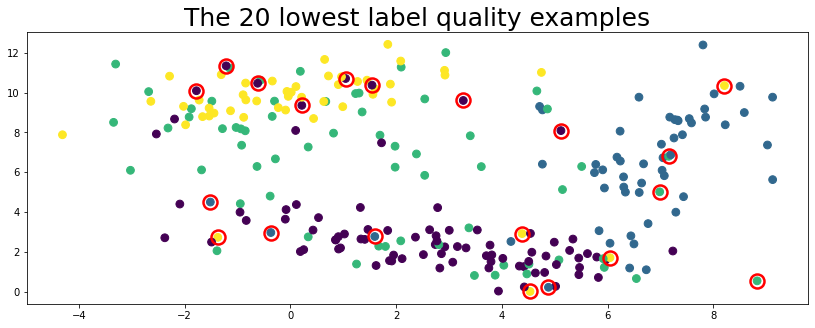

In [7]:
lowest_quality_labels = issues["label_quality"].argsort()[:20]
plot_data(data, circles=lowest_quality_labels, title="The 20 lowest label quality examples")

Above, the top 20 label issues circled in red are found automatically using cleanlab (no true labels given).

If you've already computed the label issues using ``CleanLearning``, you can pass them into `fit()` and it will train **much** faster (skips label-issue identification step).

In [8]:
# CleanLearning can train faster if issues are provided at fitting time.
cl.fit(data, labels, label_issues=issues)

CleanLearning(clf=LogisticRegression(random_state=0),
              find_label_issues_kwargs={'min_examples_per_class': 10}, seed=0)

## **Workflow 3:** Use cleanlab to find dataset-level and class-level issues

- Did you notice that the yellow and seafoam green class above are overlapping?
- How can a model ever know (or learn) what's ground truth inside the yellow distribution?
- If these two classes were merged, the model can learn more accurately from 3 classes (versus 4).

cleanlab automatically finds data-set level issues like this, in one line of code. Check this out!


In [9]:
cleanlab.dataset.find_overlapping_classes(
    labels=labels,
    confident_joint=cl.confident_joint,  # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
    class_names=class_names,
)

,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,seafoam green,yellow,2,3,26,0.104
1,purple,seafoam green,0,2,23,0.092
2,purple,yellow,0,3,10,0.040
3,blue,seafoam green,1,2,6,0.024
4,purple,blue,0,1,5,0.020
5,blue,yellow,1,3,1,0.004


Do the results surprise you? Did you expect the purple and seafoam green to also have so much overlap?

There are two things being happening here:

1. **Distribution Overlap**: The green distribution has huge variance and overlaps with other distributions.
   - Cleanlab handles this for you: read the theory behind cleanlab for overlapping classes here: https://arxiv.org/abs/1705.01936
2. **Label Issues**: A ton of examples (which actually belong to the purple class) have been mislabeled as "green" in our dataset.

### Now, let's see what happens if we merge classes "seafoam green" and "yellow"
* the top two classes found automatically by ``cleanlab.dataset.find_overlapping_classes()``

In [10]:
yourFavoriteModel1 = LogisticRegression(verbose=0, random_state=SEED)
yourFavoriteModel1.fit(data, labels)
print(f"[Original classes] Accuracy of yourFavoriteModel: {yourFavoriteModel1.score(test_data, test_labels):.0%}")

merged_labels, merged_test_labels = np.array(labels), np.array(test_labels)

# Merge classes: map all yellow-labeled examples to seafoam green
merged_labels[merged_labels == 3] = 2
merged_test_labels[merged_test_labels == 3] = 2

# Re-run our comparison. Re-run your model on the newly labeled dataset.
yourFavoriteModel2 = LogisticRegression(verbose=0, random_state=SEED)
yourFavoriteModel2.fit(data, merged_labels)
print(f"[Modified classes] Accuracy of yourFavoriteModel: {yourFavoriteModel2.score(test_data, merged_test_labels):.0%}")

# Re-run CleanLearning as well.
yourFavoriteModel3 = LogisticRegression(verbose=0, random_state=SEED)
cl3 = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=SEED)
cl3.fit(data, merged_labels)
print(f"[Modified classes] Accuracy of yourFavoriteModel (+ CleanLearning): {cl3.score(test_data, merged_test_labels):.0%}")

[Original classes] Accuracy of yourFavoriteModel: 83%
[Modified classes] Accuracy of yourFavoriteModel: 94%


[Modified classes] Accuracy of yourFavoriteModel (+ CleanLearning): 96%


While on one hand that's a huge improvement, it's important to remember that choosing among three classes is an easier task than choosing among four classes, so it's not fair to directly compare these numbers.

Instead, the big takeaway is...
if you get to choose your classes, combining overlapping classes can make the learning task easier for your model. But if you have lots of classes, how do you know which ones to merge?? That's when you use `cleanlab.dataset.find_overlapping_classes`.


## **Workflow 4:** Clean your test set too if you're doing ML with noisy labels!

If your test and training data were randomly split (IID), then be aware that your test labels are likely noisy too! It is thus important to fix label issues in them before we can trust measures like test accuracy.
* More about what can go wrong if you don't use a clean test set [in this paper](https://arxiv.org/abs/2103.14749).

In [11]:
from sklearn.metrics import accuracy_score

# Fit your model on noisily labeled train data
yourFavoriteModel = LogisticRegression(verbose=0, random_state=SEED)
yourFavoriteModel.fit(data, labels)

# Get predicted probabilities for test data (these are out-of-sample)
my_test_pred_probs = yourFavoriteModel.predict_proba(test_data)
my_test_preds = my_test_pred_probs.argmax(axis=1)  # predicted labels

# Find label issues in the test data
issues_test = CleanLearning(yourFavoriteModel, seed=SEED).find_label_issues(
    labels=noisy_test_labels, pred_probs=my_test_pred_probs)

# You should inspect issues_test and fix issues to ensure high-quality test data labels. 
corrected_test_labels = test_labels  # Here we'll pretend you have done this perfectly :)

# Fit more robust version of model on noisily labeled training data
cl = CleanLearning(yourFavoriteModel, seed=SEED).fit(data, labels)
cl_test_preds = cl.predict(test_data)

print(f" Noisy Test Accuracy (on given test labels) using yourFavoriteModel: {accuracy_score(noisy_test_labels, my_test_preds):.0%}")
print(f" Noisy Test Accuracy (on given test labels) using yourFavoriteModel (+ CleanLearning): {accuracy_score(noisy_test_labels, cl_test_preds):.0%}")
print(f"Actual Test Accuracy (on corrected test labels) using yourFavoriteModel: {accuracy_score(corrected_test_labels, my_test_preds):.0%}")
print(f"Actual Test Accuracy (on corrected test labels) using yourFavoriteModel (+ CleanLearning): {accuracy_score(corrected_test_labels, cl_test_preds):.0%}")

 Noisy Test Accuracy (on given test labels) using yourFavoriteModel: 69%
 Noisy Test Accuracy (on given test labels) using yourFavoriteModel (+ CleanLearning): 71%
Actual Test Accuracy (on corrected test labels) using yourFavoriteModel: 83%
Actual Test Accuracy (on corrected test labels) using yourFavoriteModel (+ CleanLearning): 86%


## **Workflow 5:** One score to rule them all -- use cleanlab's overall dataset health score 

This score can be fairly compared across datasets or across versions of a dataset to track overall dataset quality (a.k.a. *dataset health*) over time.


In [12]:
# One line of code.
health = cleanlab.dataset.overall_label_health_score(
    labels, confident_joint=cl.confident_joint
    # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
)

 * Overall, about 28% (71 of the 250) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.72.


### How accurate is this dataset health score?

Because we know the true labels (we created this toy dataset), we can compare with ground truth.

In [13]:
label_acc = sum(labels != true_labels) / len(labels)
print(f"Percentage of label issues guessed by cleanlab {1 - health:.0%}")
print(f"Percentage of (ground truth) label errors): {label_acc:.0%}")

offset = (1 - label_acc) - health

print(
    f"\nQuestion: cleanlab seems to be overestimating."
    f" How do we account for this {offset:.0%} difference?"
)
print(
    "Answer: Data points that fall in between two overlapping distributions are often "
    "impossible to label and are counted as issues."
)

Percentage of label issues guessed by cleanlab 28%
Percentage of (ground truth) label errors): 20%

Question: cleanlab seems to be overestimating. How do we account for this 8% difference?
Answer: Data points that fall in between two overlapping distributions are often impossible to label and are counted as issues.


## **Workflow(s) 6:** Use count, rank, filter modules directly

- Using these modules directly is intended for more experienced cleanlab users. But once you understand how they work, you can create numerous powerful workflows.
- For these workflows, you **always** need two things:
  1.  out-of-sample predicted probabilities (e.g. computed via cross-validation) 
  2.  labels (can contain label errors and various issues)

#### cleanlab can compute out-of-sample  predicted probabilities for you:


In [14]:
pred_probs = cleanlab.count.estimate_cv_predicted_probabilities(
    data, labels, clf=yourFavoriteModel, seed=SEED
)
print(f"pred_probs is a {pred_probs.shape} matrix of predicted probabilites")

pred_probs is a (250, 4) matrix of predicted probabilites


### **Workflow 6.1 (count)**: Fully characterize label noise (noise matrix, joint, prior of true labels, ...)

Now that we have `pred_probs` and `labels`, advanced users can compute everything in `cleanlab.count`.

- `py: prob(true_label=k)`
  - For all classes K, this is the distribution over the actual true labels (which cleanlab can estimate for you even though you don't have the true labels).
- `noise_matrix: p(noisy|true)`
  - This describes how errors were introduced into your labels. It's a conditional probability matrix with the probability of flipping from the true class to every other class for the given label.
- `inverse noise matrix: p(true|noisy)`
  - This tells you the probability, for every class, that the true label is actually a different class.
- `confident_joint`
  - This is an unnormalized (count-based) estimate of the number of examples in our dataset with each possible (true label, given label) pairing.
- `joint: p(true label, noisy label)`
  - The joint distribution of noisy (given) and true labels is the most useful of all these statistics. From it, you can compute every other statistic listed above. One entry from this matrix can be interpreted as: "The proportion of examples in our dataset whose true label is *i* and given label is *j*".

These five tools fully characterize class-conditional label noise in a dataset.

#### Use cleanlab to estimate and visualize the joint distribution of label noise and noise matrix of label flipping rates:

In [15]:
(
    py, noise_matrix, inverse_noise_matrix, confident_joint
) = cleanlab.count.estimate_py_and_noise_matrices_from_probabilities(labels, pred_probs)

# Note: you can also combine the above two lines of code into a single line of code like this
(
    py, noise_matrix, inverse_noise_matrix, confident_joint, pred_probs
) = cleanlab.count.estimate_py_noise_matrices_and_cv_pred_proba(
    data, labels, clf=yourFavoriteModel, seed=SEED
)

# Get the joint distribution of noisy and true labels from the confident joint
# This is the most powerful statistic in machine learning with noisy labels.
joint = cleanlab.count.estimate_joint(
    labels, pred_probs, confident_joint=confident_joint
)

# Pretty print the joint distribution and noise matrix
cleanlab.internal.util.print_joint_matrix(joint)
cleanlab.internal.util.print_noise_matrix(noise_matrix)


 Joint Label Noise Distribution Matrix P(given_label, true_label) of shape (4, 4)
 p(s,y)	y=0	y=1	y=2	y=3
	---	---	---	---
s=0 |	0.27	0.0	0.03	0.03
s=1 |	0.02	0.18	0.01	0.0
s=2 |	0.06	0.01	0.12	0.06
s=3 |	0.01	0.0	0.05	0.14
	Trace(matrix) = 0.72


 Noise Matrix (aka Noisy Channel) P(given_label|true_label) of shape (4, 4)
 p(s|y)	y=0	y=1	y=2	y=3
	---	---	---	---
s=0 |	0.76	0.0	0.15	0.14
s=1 |	0.06	0.92	0.06	0.0
s=2 |	0.17	0.06	0.57	0.25
s=3 |	0.02	0.02	0.22	0.61
	Trace(matrix) = 2.86



In some applications, you may have a priori knowledge regarding some of these quantities. In this case, you can pass them directly into cleanlab which may be able to leverage this information to better identify label issues.


In [16]:
cl3 = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=SEED)
_ = cl3.fit(data, labels, noise_matrix=noise_matrix_true)  # CleanLearning with a prioiri known noise_matrix

### **Workflow 6.2 (filter):** Find label issues for any dataset and any model in one line of code

Features of ``cleanlab.filter.find_label_issues``:
* Versatility -- Choose from several [state-of-the-art](https://arxiv.org/abs/1911.00068) label-issue detection algorithms using ``filter_by=``.
* Works with any model by using predicted probabilities (no model needed).
* one line of code :)

Remember ``CleanLearning.find_label_issues``? It uses this method internally.

In [17]:
# Get out of sample predicted probabilities via cross-validation.
# Here we demonstrate the use of sklearn cross_val_predict as another option to get cross-validated predicted probabilities
cv_pred_probs = cross_val_predict(
    estimator=yourFavoriteModel, X=data, y=labels, cv=3, method="predict_proba"
)

# Find label issues
label_issues_indices = cleanlab.filter.find_label_issues(
    labels=labels,
    pred_probs=cv_pred_probs,
    filter_by="both", # 5 available filter_by options
    return_indices_ranked_by="self_confidence",  # 3 available label quality scoring options for rank ordering
    rank_by_kwargs={
        "adjust_pred_probs": True  # adjust predicted probabilities (see docstring for more details)
    },
)

# Return dataset indices of examples with label issues
label_issues_indices

array([ 99,   8,  64,  45,  83, 213, 212, 218, 152, 197, 196, 170, 167,
       214, 164, 198,  21, 191, 107,  16,  51,  63,   2, 175,  10, 121,
       117,  24,  95,  82,  76,  26,  90,  25,  62,  22,  92,  49,  97,
       206,  68, 115,   7,  48,  43, 193, 184, 249, 194, 186, 201, 174,
       188, 163, 150, 190, 169, 151, 168,  54])


#### Again, we can visualize the twenty examples with lowest label quality to see if Cleanlab works.

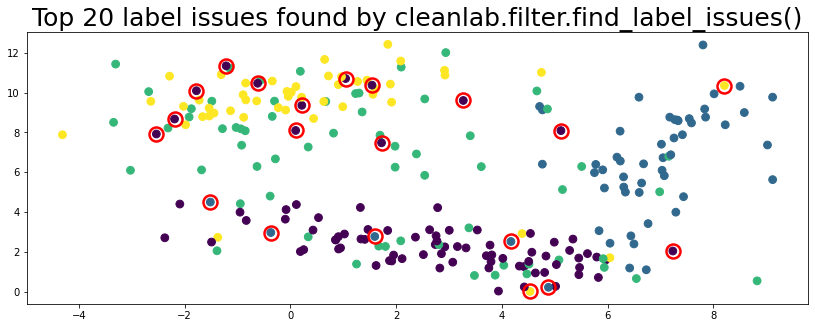

In [18]:
plot_data(data, circles=label_issues_indices[:20], title="Top 20 label issues found by cleanlab.filter.find_label_issues()")

### Workflow 6.2 supports lots of methods to ``find_label_issues()`` via the ``filter_by`` parameter.
* Here, we evaluate precision/recall/f1/accuracy of detecting true label issues for each method.

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

yourFavoriteModel = LogisticRegression(verbose=0, random_state=SEED)

# Get cross-validated predicted probabilities
# Here we demonstrate the use of sklearn cross_val_predict as another option to get cross-validated predicted probabilities
cv_pred_probs = cross_val_predict(
    estimator=yourFavoriteModel, X=data, y=labels, cv=3, method="predict_proba"
)

# Ground truth label issues to use for evaluating different filter_by options
true_label_issues = (true_labels != labels)

# Find label issues with different filter_by options
filter_by_list = [
    "prune_by_noise_rate",
    "prune_by_class",
    "both",
    "confident_learning",
    "predicted_neq_given",
]

results = []

for filter_by in filter_by_list:

    # Find label issues
    label_issues = cleanlab.filter.find_label_issues(
        labels=labels, 
        pred_probs=cv_pred_probs, 
        filter_by=filter_by
    )
    
    precision = precision_score(true_label_issues, label_issues)
    recall = recall_score(true_label_issues, label_issues)
    f1 = f1_score(true_label_issues, label_issues)
    acc = accuracy_score(true_label_issues, label_issues)
    
    result = {
        "filter_by algorithm": filter_by,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc
    }
    
    results.append(result)

# summary of results
pd.DataFrame(results).sort_values(by='f1', ascending=False)

,filter_by algorithm,precision,recall,f1,accuracy
0,prune_by_noise_rate,0.718750,0.92,0.807018,0.912
2,both,0.733333,0.88,0.800000,0.912
3,confident_learning,0.721311,0.88,0.792793,0.908
1,prune_by_class,0.676923,0.88,0.765217,0.892
4,predicted_neq_given,0.567901,0.92,0.702290,0.844


### **Workflow 6.3 (rank):** Automatically rank every example by a unique label quality score. Find errors using `cleanlab.count.num_label_issues` as a threshold.

cleanlab can analyze every label in a dataset and provide a numerical score gauging its overall quality. Low-quality labels indicate examples that should be more closely inspected, perhaps because their given label is incorrect, or simply because they represent an ambiguous edge-case that's worth a second look.

In [20]:
# Estimate the number of label issues
label_issues_count = cleanlab.count.num_label_issues(
    labels=labels,
    pred_probs=cv_pred_probs
)

# Get label quality scores
label_quality_scores = cleanlab.rank.get_label_quality_scores(
    labels=labels,
    pred_probs=cv_pred_probs,
    method="self_confidence"
)

# Rank-order by label quality scores and get the top estimated number of label issues
label_issues_indices = np.argsort(label_quality_scores)[:label_issues_count]

label_issues_indices

array([ 99,   8,  64, 107,  10,  16,  51,  63, 121, 213, 212, 218, 117,
         2, 152, 197, 196, 170,  45,  24, 167,  83,  95,  82,  76,  26,
        90, 214, 164,  25,  62,  22, 198,  92,  21, 191,  49,  97,  68,
       115,   7,  48,  43, 193, 184, 194, 186, 174, 188, 163, 155, 150,
       190, 169, 156, 151, 168,  54, 172, 176, 157, 173, 158, 165, 171,
       175, 236, 220, 183, 160, 225, 166, 161, 154, 192, 206, 199, 128,
       162, 153,  56, 180,  80,  40, 195,  44, 113,  94,  73, 142, 177,
       249, 185, 187, 135, 182, 226,  74, 201, 203])

#### Again, we can visualize the label issues found to see if Cleanlab works.

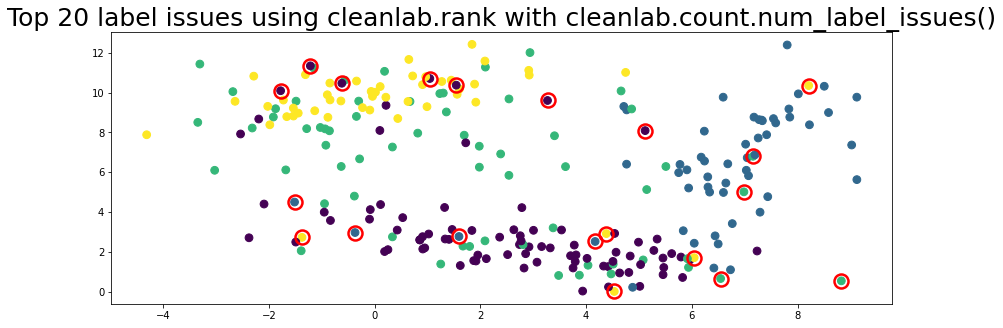

In [21]:
plot_data(data, circles=label_issues_indices[:20], title="Top 20 label issues using cleanlab.rank with cleanlab.count.num_label_issues()")

#### Not sure when to use Workflow 6.2 or 6.3 to find label issues?

* Workflow 6.2 is the easiest to use as its just one line of code.
* Workflow 6.3 is modular and extensible. As we add more label and data quality scoring functions in ``cleanlab.rank``, Workflow 6.3 will always work.
* Workflow 6.3 is also for users who have a custom way to rank their data by label quality, and they just need to know what the cut-off is, found via ``cleanlab.count.num_label_issues``.

## **Workflow 7:** Ensembling label quality scores from multiple predictors

In [22]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# 3 models in ensemble
model1 = LogisticRegression(penalty="l2", verbose=0, random_state=SEED)
model2 = RandomForestClassifier(max_depth=5, random_state=SEED)
model3 = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=3, random_state=SEED
)

# Get cross-validated predicted probabilities from each model
cv_pred_probs_1 = cross_val_predict(
    estimator=model1, X=data, y=labels, cv=3, method="predict_proba"
)
cv_pred_probs_2 = cross_val_predict(
    estimator=model2, X=data, y=labels, cv=3, method="predict_proba"
)
cv_pred_probs_3 = cross_val_predict(
    estimator=model3, X=data, y=labels, cv=3, method="predict_proba"
)

# List of predicted probabilities from each model
pred_probs_list = [cv_pred_probs_1, cv_pred_probs_2, cv_pred_probs_3]  

# Get ensemble label quality scores
label_quality_scores_best = cleanlab.rank.get_label_quality_ensemble_scores(
    labels=labels, pred_probs_list=pred_probs_list, verbose=False
)

# Alternative approach: create single ensemble predictor and get its pred_probs
cv_pred_probs_ensemble = (cv_pred_probs_1 + cv_pred_probs_2 + cv_pred_probs_3)/3  # uniform aggregation of predictions

# Use this single set of pred_probs to find label issues
label_quality_scores_better = cleanlab.rank.get_label_quality_scores(
    labels=labels, pred_probs=cv_pred_probs_ensemble
)

While ensembling different models' label quality scores (`label_quality_scores_best`) will often be superior to getting label quality scores from a single ensemble predictor (`label_quality_scores_better`), both approaches produce significantly better label quality scores than just using the predictions from a single model. 